In [1]:
%load_ext autoreload
%autoreload 2

In [21]:
import panflute as pf
import io
pf.convert_text("<img src='b' href='wfw' id='#fig:exp'>", 'html')

[Plain(Image(; url='b', identifier='#fig:exp'))]

In [16]:
from pathlib import Path

src = Path("../figure_code/amk_chapter/visual_kitaev_1.svg")
base = Path("../figure_code")
new_base = Path("/assets/thesis_figs")
new_base / src.relative_to(base)

PosixPath('/assets/thesis_figs/amk_chapter/visual_kitaev_1.svg')

In [173]:
eg.make_amorphous?

Signature:
eg.make_amorphous(
    L,
    return_points=False,
    open_boundary_conditions=False,
    rng=None,
    shift_vertices=True,
)
Docstring: <no docstring>
File:      ~/git/koala/src/koala/example_graphs.py
Type:      function


<AxesSubplot:>

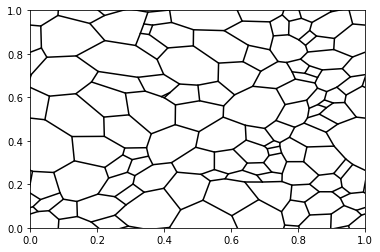

In [2]:
from koala import plotting as pl
from koala import example_graphs as eg

l, coloring, _ = eg.make_amorphous(10)

pl.plot_edges(l)

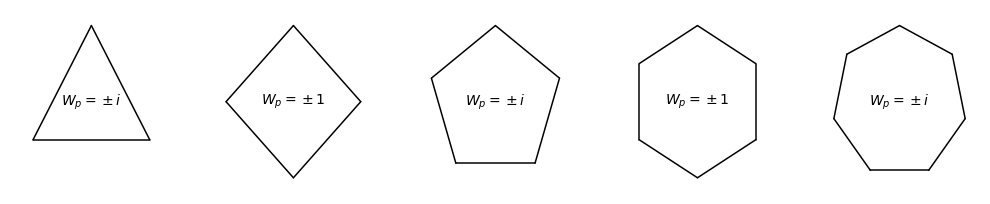

In [3]:
import matplotlib.pyplot as plt
from koala import plotting as pl
from koala import example_graphs as eg

Ns= [3,4,5,6,7]

w = 3.5
f, axes = plt.subplots(ncols = len(Ns), figsize = (w*len(Ns), w))

for n, ax in zip(Ns, axes):
    l = eg.single_plaquette(n)
    pl.plot_edges(l,ax = ax)
    ax.text(0.5,0.5, r"$W_p = \pm i$" if n%2 else r"$W_p = \pm 1$", ha = "center", va = "center", fontsize = 14)
    ax.axis("off")

In [4]:
from dataclasses import dataclass
import numpy as np
import operator
import functools
import itertools as it

def product(iterable): return functools.reduce(operator.mul, iterable, 1)
def factorial(n): return product(range(1,n+1))
def commutator(a,b): return a@b - b@a

def epsilon(*args):
    n = len(args)
    return product(
        product(args[j] - args[i] for j in range(i, n-1))
        // factorial(i) for i in range(n))

@dataclass
class Spin:
    """A spin represented by pauli matrices in the z basis"""
    x = np.array([[0,1],[1,0]])
    y = np.array([[0,-1j],[1j,0]])
    z = np.array([[1,0],[0,-1]])
    index = None
    
    def __getitem__(self, key):
        return np.array([self.x,self.y,self.z])[key]
    
p = Spin()
# Check [sigma_a, sigma_a] = 0
for i in range(3): assert np.allclose(commutator(p[i], p[i]), 0)

# for i, j, k in it.product(range(3), repeat = 3):
#     print((i,j), commutator(p[i], p[j]) - 2 * sum(epsilon(i,j,k) * p[k] for k in range(3)))


[70, 135, 72, 139, 140, 78, 104, 42, 107, 111, 113, 115, 116, 117, 122, 125]


[[], []]

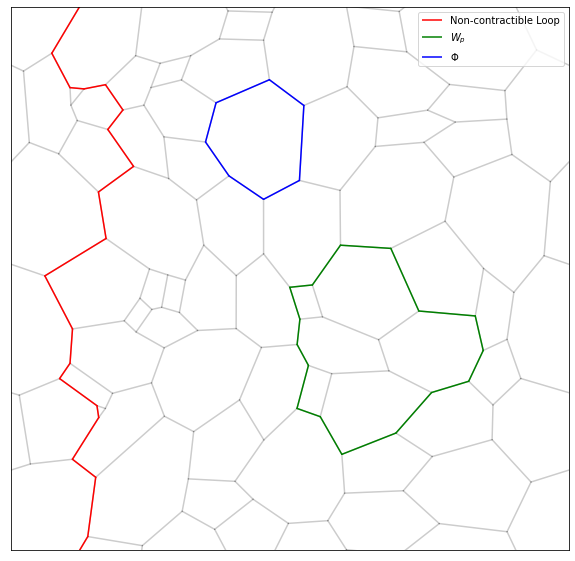

In [26]:
from koala import plotting as pl
from koala import example_graphs as eg
from koala.flux_finder import pathfinding

import functools

rng = np.random.default_rng(seed = 10)
l, coloring, _ = eg.make_amorphous(8, rng = rng)

f, ax = plt.subplots(figsize = (10,10))


# pl.plot_vertex_indices(l, ax = ax)
# pl.plot_edge_indices(l, ax = ax)
# pl.plot_plaquette_indices(l, ax = ax)

vertices, edges = pathfinding.path_between_vertices(l, 24, 53)
vertices, edges2 = pathfinding.path_between_vertices(l, 23, 53)

noncontractible_loop = edges + edges2 + [157,]

plaquettes = [40, 52, 41, 43, 53, 30]
W_p = list(functools.reduce(lambda a,b: a^b, [set(l.plaquettes[i].edges) for i in plaquettes]))
print(W_p)

pl.plot_edges(l, ax = ax, alpha = 0.2)
pl.plot_edges(l, ax = ax, subset = noncontractible_loop, color = "r", label = "Non-contractible Loop")
pl.plot_edges(l, ax = ax, subset = W_p, color = "g", label = "$W_p$")
pl.plot_edges(l, ax = ax, subset = l.plaquettes[49].edges, color = "b", label = "$\Phi$")

ax.legend()
ax.set(xticks = [], yticks = [])

In [319]:
l.plaquettes[0]

Plaquette(vertices=array([57, 58, 17, 18, 60, 14]), edges=array([  0, 184, 136, 141,  73, 180]), directions=array([ 1, -1,  1, -1, -1,  1]), center=array([0.93740921, 0.22612617]), n_sides=6, adjacent_plaquettes=array([ 1,  9, 56, 42, 13, 23]))

<AxesSubplot:>

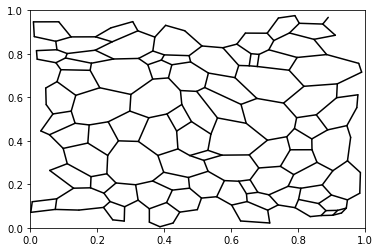

In [273]:
from koala.lattice import INVALID
n_adjacent_plaquettes = 3 - np.sum(l.vertices.adjacent_plaquettes == INVALID, axis = -1)
hanging_verts = np.where(n_adjacent_plaquettes < 1)[0]

bad_edges = set(it.chain(l.vertices.adjacent_edges[i][0] for i in hanging_verts))
good_edges = set(range(l.n_edges)) - bad_edges
good_mask = np.array([i in good_edges for i in range(l.n_edges)])

pl.plot_edges(l, subset = good_mask)

(0.0, 1.0, 0.0, 1.0)

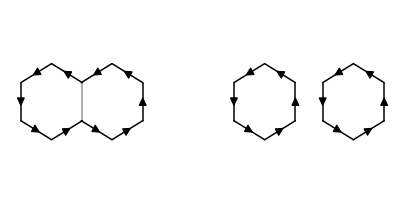

In [83]:
import matplotlib.pyplot as plt
from koala import plotting as pl
from koala import example_graphs as eg

Ns= [3,4,5,6,7]



def transform_lattice(l, translate = np.array([0,0]), scale = 1):
    """
    Return a new lattice with vertex positions p' = (p*scale) + translate
    Does not attempt to deal with periodic boundary conditions
    """
    return Lattice(l.vertices.positions*scale + translate[None, :], l.edges.indices, l.edges.crossing)
    
w = 3.5
f, axes = plt.subplots(ncols = 2, figsize = (w*2, w))

ax = axes[1]
l = transform_lattice(eg.single_plaquette(6), scale = 0.5, translate = np.array([0,0.25]))
pl.plot_edges(l,ax = ax, directions = True, arrow_head_length = 0.04)

l1 = transform_lattice(l, translate = np.array([0.5, 0]))
pl.plot_edges(l1, ax = ax, directions = True, arrow_head_length = 0.04)

ax.axis("off")

ax = axes[0]
l = transform_lattice(eg.single_plaquette(6), scale = 0.5, translate = np.array([0,0.25]))
pl.plot_edges(l,ax = ax, directions = True, arrow_head_length = 0.04, subset = [0,1,2,3,5])
pl.plot_edges(l,ax = ax, subset = [4,], alpha = 0.4)


l1 = transform_lattice(l, translate = np.array([0.34, 0]))
pl.plot_edges(l1, ax = ax, directions = True, arrow_head_length = 0.04, subset = [0,2,3,4,5])
# pl.plot_edge_indices(l1, ax=ax)
ax.axis("off")

[[]]

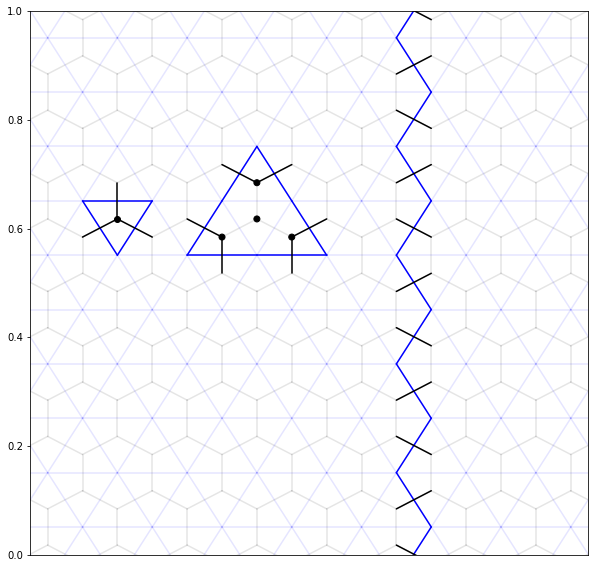

In [54]:
from koala import plotting as pl
from koala import example_graphs as eg
from koala.flux_finder import pathfinding

import functools

# rng = np.random.default_rng(seed = 10)
# l, coloring, _ = eg.make_amorphous(8, rng = rng)
l, coloring, _ = eg.make_honeycomb(8)


f, ax = plt.subplots(figsize = (10,10))



# pl.plot_vertex_indices(l, ax = ax)
# pl.plot_edge_indices(l, ax = ax)
# pl.plot_plaquette_indices(l, ax = ax)

single_vertex = 100


subset = l.vertices.adjacent_edges[single_vertex]
pl.plot_dual(l, ax = ax, color = 'blue', subset = subset)
pl.plot_edges(l, ax = ax, color = 'k', subset = subset)
pl.plot_vertices(l, ax = ax, subset = [single_vertex])

pl.plot_edges(l, ax = ax, alpha = 0.1)
pl.plot_dual(l, ax = ax, color = 'blue', alpha = 0.1)

def multi_set_symmetric_difference(sets):
    return list(functools.reduce(lambda a,b: a^b, [set(s) for s in sets]))

multi_verts = [108, 75, 79, 109]
multi_edges = multi_set_symmetric_difference([l.vertices.adjacent_edges[v] for v in multi_verts])
pl.plot_dual(l, ax = ax, color = 'blue', subset = multi_edges)
pl.plot_edges(l, ax = ax, color = 'k', subset = multi_edges)
pl.plot_vertices(l, ax = ax, subset = multi_verts)

_, edges = pathfinding.path_between_plaquettes(l, 76, 12)
_, edges2 = pathfinding.path_between_plaquettes(l, 75, 12)
edges = edges + edges2 + [112,]

pl.plot_dual(l, ax = ax, color = 'blue', subset = edges)
pl.plot_edges(l, ax = ax, color = 'k', subset = edges)

ax.set(xticks = [])

[[], []]

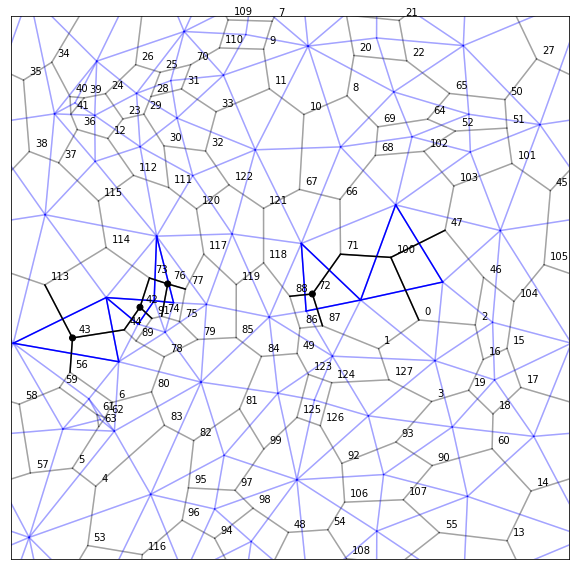

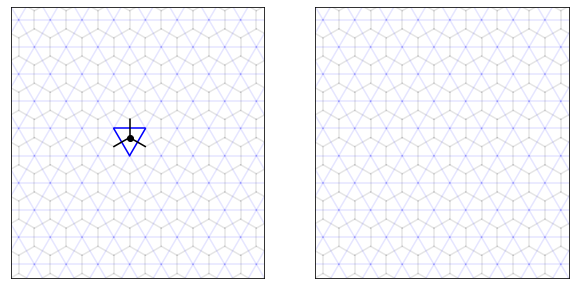

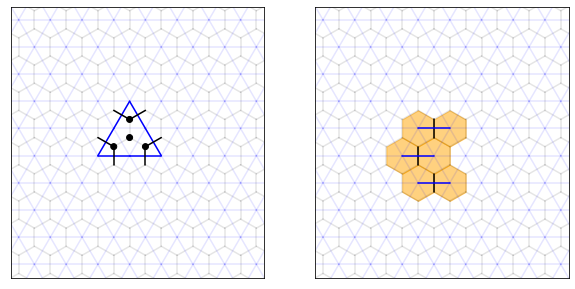

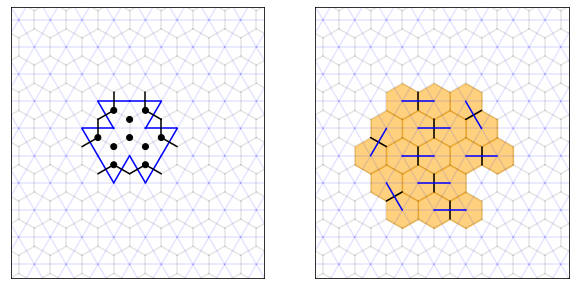

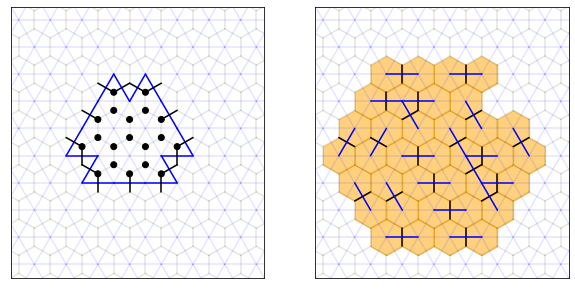

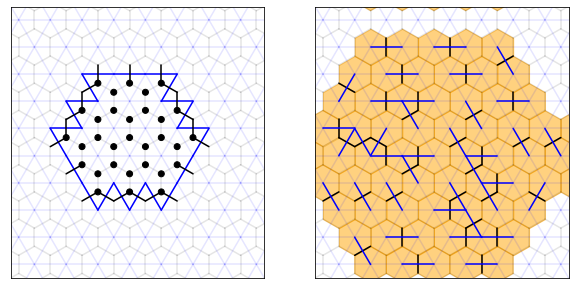

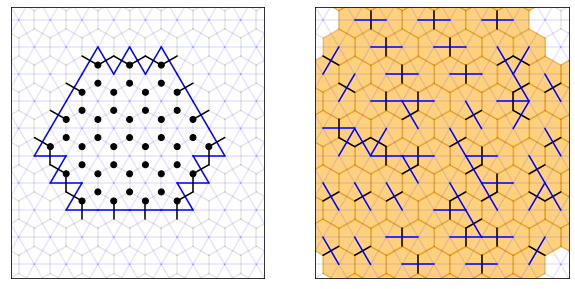

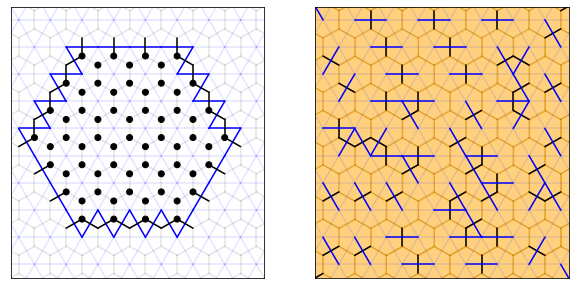

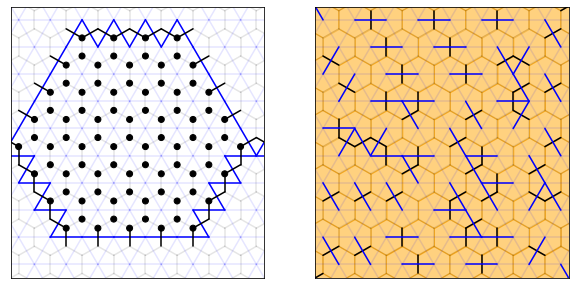

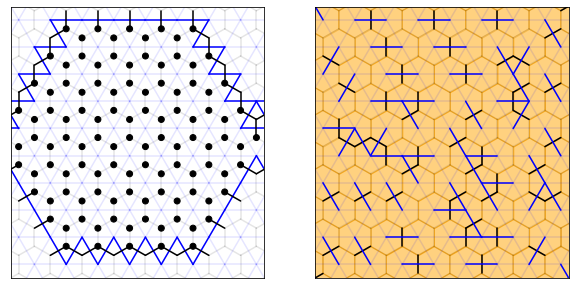

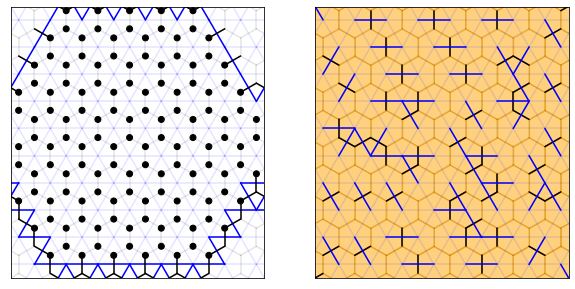

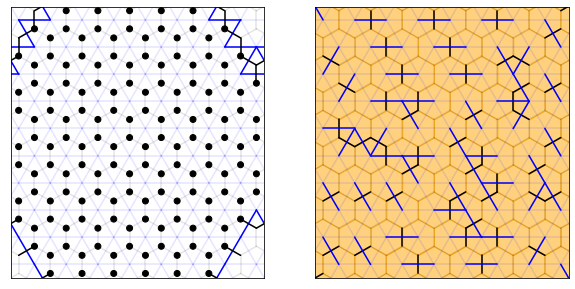

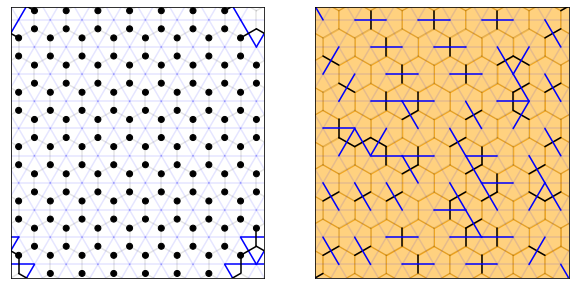

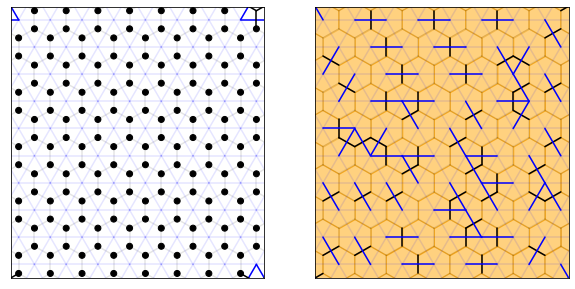

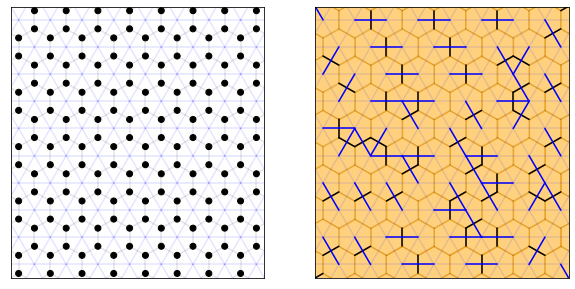

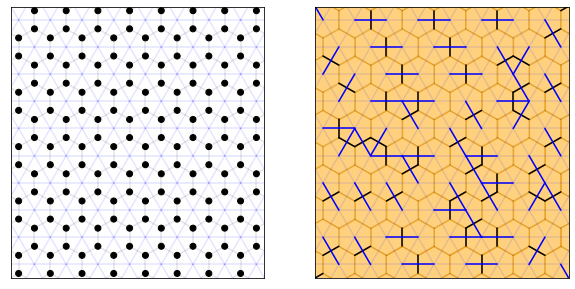

In [95]:
from koala import plotting as pl
from koala import example_graphs as eg
from koala.flux_finder import pathfinding
from matplotlib import pyplot as plt

import functools

def multi_set_symmetric_difference(sets):
    return list(functools.reduce(lambda a,b: a^b, [set(s) for s in sets]))

def flood_iteration_plaquettes(l, plaquettes):
    return set(plaquettes) | set(it.chain.from_iterable(l.plaquettes[p].adjacent_plaquettes for p in plaquettes))

def flood_iteration_vertices(l, vertices):
    return set(vertices) | set(it.chain.from_iterable(i for v in set(vertices) for i in l.edges.indices[l.vertices.adjacent_edges[v]]))

# rng = np.random.default_rng(seed = 10)
# l, coloring, _ = eg.make_amorphous(8, rng = rng)
l, coloring, ujk = eg.make_honeycomb(8)

plaquettes = [40,]
vertices = [78,]

for n in range(15):
    f, axes = plt.subplots(ncols = 2, figsize = (10,5))

    # pl.plot_vertex_indices(l, ax = ax)
    # pl.plot_edge_indices(l, ax = ax)
    # pl.plot_plaquette_indices(l, ax = ax)
    
    if n > 0:
        vertices = flood_iteration_vertices(l, vertices)
        plaquettes = flood_iteration_plaquettes(l, plaquettes)
    
    
    ax = axes[0]
    
    multi_edges = multi_set_symmetric_difference([l.vertices.adjacent_edges[v] for v in vertices])
    
    if multi_edges: pl.plot_dual(l, ax = ax, color = 'blue', subset = multi_edges)
    pl.plot_edges(l, ax = ax, color = 'k', subset = multi_edges)
    pl.plot_vertices(l, ax = ax, subset = list(vertices))

    pl.plot_edges(l, ax = ax, alpha = 0.1)
    pl.plot_dual(l, ax = ax, color = 'blue', alpha = 0.1)

    ax.set(xticks = [], yticks = [])
    
    ax = axes[1]

    plaquette_boolean = np.array([i in plaquettes for i in range(l.n_plaquettes)])

    fluxes = 1 - 2*plaquette_boolean
    ujk = flux_finder.find_flux_sector(l, fluxes, ujk)
    fluxes = flux_finder.fluxes_from_bonds(l, ujk)

    pl.plot_edges(l, ax = ax, alpha = 0.1)
    pl.plot_dual(l, ax = ax, color = 'blue', alpha = 0.1)
    
    pl.plot_edges(l, ax = ax, subset = (ujk == -1))
    if len(plaquettes) > 1: pl.plot_dual(l, ax = ax, subset = (ujk == -1), color = 'blue')
    pl.plot_plaquettes(l, subset = fluxes == -1, ax = ax, color_scheme = ["orange", "white"], alpha = 0.5);
    ax.set(xticks = [], yticks = [])
    
    if n == 3: f.savefig(f"flood_fill_still.svg")
    f.savefig(f"animations/flood_fill/iteration_{n:03}.svg")

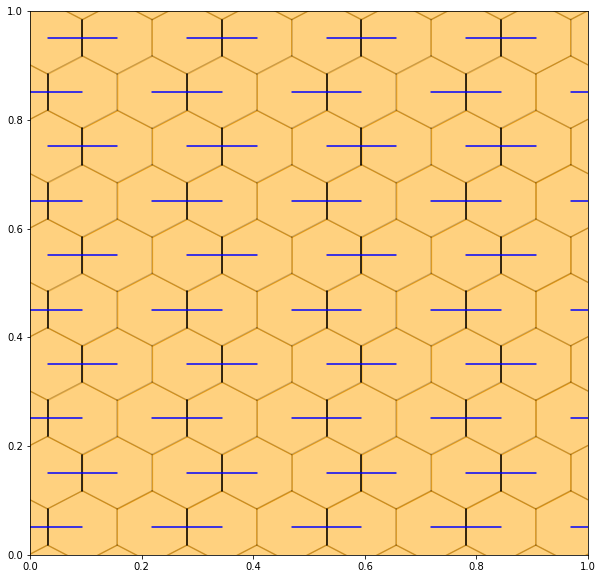

In [68]:
from koala import plotting as pl
from koala import example_graphs as eg
from koala.flux_finder import pathfinding, flux_finder
import matplotlib.pyplot as plt
import itertools as it
import numpy as np
import functools

l, coloring, gs_ujk = eg.make_honeycomb(8)
fluxes = flux_finder.fluxes_from_bonds(l, ujk)





def flood_iteration_plaquettes(l, plaquettes):
    return set(plaquettes) | set(it.chain.from_iterable(l.plaquettes[p].adjacent_plaquettes for p in plaquettes))

def flood_plaquettes(l, p, n):
    for _ in range(n):
        p = flood_iteration_plaquettes(l, p)
    return p


f, ax = plt.subplots(figsize = (10,10))

plaquettes = [40,]

plaquettes = flood_plaquettes_iteration(l, plaquettes)
plaquette_boolean = np.array([i in plaquettes for i in range(l.n_plaquettes)])

fluxes = 1 - 2*plaquette_boolean
ujk = flux_finder.find_flux_sector(l, fluxes, gs_ujk)
fluxes = flux_finder.fluxes_from_bonds(l, ujk)

pl.plot_edges(l, ax = ax, alpha = 0.2)
pl.plot_edges(l, ax = ax, subset = (ujk == -1))
if len(plaquettes) > 1: pl.plot_dual(l, ax = ax, subset = (ujk == -1), color = 'blue')
pl.plot_plaquettes(l, subset = fluxes == -1, ax = ax, color_scheme = ["orange", "white"], alpha = 0.5);
# pl.plot_plaquette_indices(l, ax = ax)

In [34]:
import itertools as it

plaquettes = [40, 42]


{23, 25, 27, 38, 39, 40, 41, 42, 43, 44}

In [31]:
it.chain.from_iterable

Init signature: it.chain(self, /, *args, **kwargs)
Docstring:     
chain(*iterables) --> chain object

Return a chain object whose .__next__() method returns elements from the
first iterable until it is exhausted, then elements from the next
iterable, until all of the iterables are exhausted.
Type:           type
Subclasses:     
